In [4]:
"""
WEED DETECTION SYSTEM - HYBRID YOLOv8 + CNN BACKBONE
"""
import os
import sys
import yaml
import torch
import torch.nn as nn
import traceback
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor

import ultralytics
import ultralytics.nn.tasks as tasks
import ultralytics.nn.modules as modules_pkg

# GLOBAL FEATURE CACHE
FEATURE_CACHE = {'p3': None, 'p4': None, 'p5': None}

class CustomBackbone(nn.Module):
    def __init__(self, c2, model_name):
        super().__init__()
        if isinstance(model_name, list): model_name = model_name[0]
        self.model_name = str(model_name)
        print(f"\n[INFO] Initializing Custom Backbone: {self.model_name.upper()}")

        if self.model_name == 'resnet50':
            weights = models.ResNet50_Weights.DEFAULT
            base_model = models.resnet50(weights=weights)
            nodes = {'layer2': 'p3', 'layer3': 'p4', 'layer4': 'p5'}
        elif self.model_name == 'densenet121':
            weights = models.DenseNet121_Weights.DEFAULT
            base_model = models.densenet121(weights=weights)
            nodes = {'features.transition1.pool': 'p3', 'features.transition2.pool': 'p4', 'features.norm5': 'p5'}
        else:
            raise ValueError(f"Unsupported model type: {self.model_name}")

        self.feature_extractor = create_feature_extractor(base_model, return_nodes=nodes)

    def forward(self, x):
        try:
            outputs = self.feature_extractor(x)
            global FEATURE_CACHE
            FEATURE_CACHE['p3'] = outputs['p3'].detach()
            FEATURE_CACHE['p4'] = outputs['p4'].detach()
            FEATURE_CACHE['p5'] = outputs['p5'].detach() 
            return outputs['p5'] # Returns 1024ch tensor, but Parser tracks as 3ch (Unknown Module). Ignored by Index.
        except Exception as e: 
            print(f"DEBUG: CustomBackbone Forward Failed: {e}")
            traceback.print_exc()
            return x

class FeatureSelector(nn.Module):
    """
    Hijacks 'Index' module in Ultralytics.
    YAML: [c2, index] -> Parser sets c2, passes [index] to __init__.
    """
    def __init__(self, index):
        super().__init__()
        self.index = int(index)

    def forward(self, x):
        try:
            global FEATURE_CACHE
            keys = ['p3', 'p4', 'p5']
            target_key = keys[self.index]
            out = FEATURE_CACHE[target_key]
            if out is None:
                 raise RuntimeError(f"Cache miss for {target_key}")
            return out
        except Exception as e:
            print(f"DEBUG: FS Forward Failed: {e}")
            return x
        

    

def register_custom_modules():
    # Hijack tasks.Index
    # Ultralytics parse_model uses 'if m in ({... Index})' and 'c2 = args[0]'.
    # We replace the class so it uses FeatureSelector instantiation logic.
    setattr(tasks, 'Index', FeatureSelector)
    print("[INFO] Hijacked tasks.Index with FeatureSelector")
    
    setattr(tasks, 'CustomBackbone', CustomBackbone)
    setattr(modules_pkg, 'CustomBackbone', CustomBackbone)

def generate_model_yaml(model_type, nc, path='custom_model.yaml'):
    if model_type == 'resnet50': ch_p3, ch_p4, ch_p5 = 512, 1024, 2048
    else: ch_p3, ch_p4, ch_p5 = 128, 256, 1024
    
    yaml_content = f"""
nc: {nc}
scales:
  l: [1.00, 1.00, 1024]

backbone:
  # CustomBackbone (Unknown Module). c2 defaults to c1 (3).
  # Args: [c2, model_name] (c2 arg is ignored by parser for updating ch list, but passed to init)
  - [-1, 1, CustomBackbone, [{ch_p5}, '{model_type}']]
  
  # Index (FeatureSelector). Known Module.
  # Parser logic: c2 = args[0]. args = args[1:].
  # YAML Args: [c2, index] -> c2 updated to correct ch. Init called with index.
  - [0, 1, Index, [{ch_p3}, 0]]
  - [0, 1, Index, [{ch_p4}, 1]]
  - [0, 1, Index, [{ch_p5}, 2]]

head:
  - [3, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 2], 1, Concat, [1]]
  - [-1, 3, C2f, [512]]

  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 1], 1, Concat, [1]]
  - [-1, 3, C2f, [256]]

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 6], 1, Concat, [1]]
  - [-1, 3, C2f, [512]]

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 3], 1, Concat, [1]]
  - [-1, 3, C2f, [512]]

  - [[9, 12, 15], 1, Detect, [nc]]
"""
    with open(path, 'w') as f: f.write(yaml_content)

def main():
    MODEL_TYPE = 'densenet121'
    DATASET_YAML = '/mnt/volume1/Final year project/weedDataset/data.yaml'
    EPOCHS = 50
    IMGSZ = 640
    BATCH_SIZE = 2
    PROJECT_NAME = 'weed_detection_hybrid'
    
    if not os.path.exists(DATASET_YAML):
        print(f"[ERROR] missing {DATASET_YAML}"); sys.exit(1)
        
    with open(DATASET_YAML, 'r') as f:
        data_cfg = yaml.safe_load(f)
        nc = data_cfg.get('nc', 2)

    register_custom_modules()
    generate_model_yaml(MODEL_TYPE, nc, f'yolov8_{MODEL_TYPE}.yaml')

    from ultralytics import YOLO
    try:
        model = YOLO(f'yolov8_{MODEL_TYPE}.yaml', task='detect')
        print("[INFO] Model initialized successfully.")
        
        # Dry run for verification (1 epoch)
        model.train(data=DATASET_YAML, epochs=100, imgsz=IMGSZ, batch=BATCH_SIZE, project=PROJECT_NAME, name=f'{MODEL_TYPE}_run', verbose=True)
    except Exception as e:
        print(f"[CRITICAL ERROR] {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()


[INFO] Hijacked tasks.Index with FeatureSelector
WARNING ⚠️ no model scale passed. Assuming scale='l'.

[INFO] Initializing Custom Backbone: DENSENET121
[INFO] Model initialized successfully.
New https://pypi.org/project/ultralytics/8.4.7 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.4.2 🚀 Python-3.13.11 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5806MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/mnt/volume1/Final year project/weedDataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,

<>:66: SyntaxWarning: invalid escape sequence '\w'
<>:66: SyntaxWarning: invalid escape sequence '\w'
C:\Users\dhamo\AppData\Local\Temp\ipykernel_23884\1863976658.py:66: SyntaxWarning: invalid escape sequence '\w'
  image_path = "..\weed1.jpg"


[INFO] Custom modules registered. Ready to load hybrid model.

image 1/1 d:\Weed-detection-system\model 2 develop\..\weed1.jpg: 640x640 24 weeds, 1558.4ms
Speed: 7.7ms preprocess, 1558.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


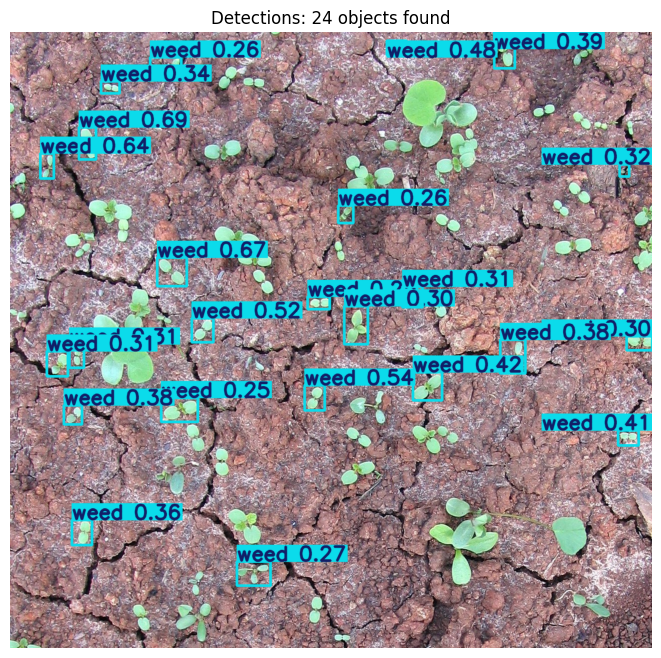

Class: weed | Confidence: 0.69
Class: weed | Confidence: 0.67
Class: weed | Confidence: 0.64
Class: weed | Confidence: 0.54
Class: weed | Confidence: 0.52
Class: weed | Confidence: 0.48
Class: weed | Confidence: 0.42
Class: weed | Confidence: 0.41
Class: weed | Confidence: 0.39
Class: weed | Confidence: 0.38
Class: weed | Confidence: 0.38
Class: weed | Confidence: 0.36
Class: weed | Confidence: 0.34
Class: weed | Confidence: 0.32
Class: weed | Confidence: 0.31
Class: weed | Confidence: 0.31
Class: weed | Confidence: 0.31
Class: weed | Confidence: 0.30
Class: weed | Confidence: 0.30
Class: weed | Confidence: 0.27
Class: weed | Confidence: 0.26
Class: weed | Confidence: 0.26
Class: weed | Confidence: 0.25
Class: weed | Confidence: 0.25


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor
import ultralytics.nn.tasks as tasks
import ultralytics.nn.modules as modules_pkg
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# --- 1. DEFINE CUSTOM HYBRID ARCHITECTURE ---

# Global cache to hold intermediate features from the backbone
FEATURE_CACHE = {'p3': None, 'p4': None, 'p5': None}

class CustomBackbone(nn.Module):
    def __init__(self, c2, model_name):
        super().__init__()
        if isinstance(model_name, list): model_name = model_name[0]
        self.model_name = str(model_name)

        if self.model_name == 'resnet50':
            weights = models.ResNet50_Weights.DEFAULT
            base_model = models.resnet50(weights=weights)
            nodes = {'layer2': 'p3', 'layer3': 'p4', 'layer4': 'p5'}
        elif self.model_name == 'densenet121':
            weights = models.DenseNet121_Weights.DEFAULT
            base_model = models.densenet121(weights=weights)
            nodes = {'features.transition1.pool': 'p3', 'features.transition2.pool': 'p4', 'features.norm5': 'p5'}
        else:
            raise ValueError(f"Unsupported model type: {self.model_name}")

        self.feature_extractor = create_feature_extractor(base_model, return_nodes=nodes)

    def forward(self, x):
        outputs = self.feature_extractor(x)
        global FEATURE_CACHE
        FEATURE_CACHE['p3'] = outputs['p3'].detach()
        FEATURE_CACHE['p4'] = outputs['p4'].detach()
        FEATURE_CACHE['p5'] = outputs['p5'].detach() 
        return outputs['p5']

class FeatureSelector(nn.Module):
    def __init__(self, index):
        super().__init__()
        self.index = int(index)

    def forward(self, x):
        global FEATURE_CACHE
        keys = ['p3', 'p4', 'p5']
        target_key = keys[self.index]
        return FEATURE_CACHE[target_key]

# --- 2. REGISTER MODULES (THE HIJACK) ---
# This tells Ultralytics how to interpret the custom layers in your .pt file
setattr(tasks, 'Index', FeatureSelector)
setattr(tasks, 'CustomBackbone', CustomBackbone)
setattr(modules_pkg, 'CustomBackbone', CustomBackbone)

print("[INFO] Custom modules registered. Ready to load hybrid model.")

# --- 3. LOAD AND RUN INFERENCE ---

# Path to your best weights
model_path = "best.pt"
image_path = "..\weed1.jpg"

# Initialize model
model = YOLO(model_path)

# Run prediction
results = model.predict(source=image_path, conf=0.25)

# --- 4. DISPLAY RESULTS IN NOTEBOOK ---
for r in results:
    # Plot detections
    im_array = r.plot() 
    # Convert BGR to RGB
    im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(im_rgb)
    plt.axis('off')
    plt.title(f"Detections: {len(r.boxes)} objects found")
    plt.show()

    # Print counts for verification
    if len(r.boxes) > 0:
        for box in r.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            print(f"Class: {model.names[cls]} | Confidence: {conf:.2f}")

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor
import ultralytics.nn.tasks as tasks
import ultralytics.nn.modules as modules_pkg
from ultralytics import YOLO
import cv2
import os

# --- 1. DEFINE CUSTOM HYBRID ARCHITECTURE (Keep as is) ---
FEATURE_CACHE = {'p3': None, 'p4': None, 'p5': None}

class CustomBackbone(nn.Module):
    def __init__(self, c2, model_name):
        super().__init__()
        if isinstance(model_name, list): model_name = model_name[0]
        self.model_name = str(model_name)
        if self.model_name == 'resnet50':
            weights = models.ResNet50_Weights.DEFAULT
            base_model = models.resnet50(weights=weights)
            nodes = {'layer2': 'p3', 'layer3': 'p4', 'layer4': 'p5'}
        elif self.model_name == 'densenet121':
            weights = models.DenseNet121_Weights.DEFAULT
            base_model = models.densenet121(weights=weights)
            nodes = {'features.transition1.pool': 'p3', 'features.transition2.pool': 'p4', 'features.norm5': 'p5'}
        self.feature_extractor = create_feature_extractor(base_model, return_nodes=nodes)

    def forward(self, x):
        outputs = self.feature_extractor(x)
        global FEATURE_CACHE
        FEATURE_CACHE['p3'], FEATURE_CACHE['p4'], FEATURE_CACHE['p5'] = outputs['p3'], outputs['p4'], outputs['p5']
        return outputs['p5']

class FeatureSelector(nn.Module):
    def __init__(self, index):
        super().__init__()
        self.index = int(index)
    def forward(self, x):
        return FEATURE_CACHE[['p3', 'p4', 'p5'][self.index]]

setattr(tasks, 'Index', FeatureSelector)
setattr(tasks, 'CustomBackbone', CustomBackbone)
setattr(modules_pkg, 'CustomBackbone', CustomBackbone)

# --- 2. CONFIGURATION ---
model_path = "best.pt"
video_path = "path/to/your/video.mp4" # Update this
output_folder = "cropped_weeds"
os.makedirs(output_folder, exist_ok=True)

# Initialize model
model = YOLO(model_path)

# --- 3. VIDEO PROCESSING LOOP ---
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Setup Video Writer to save the annotated video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_detection.mp4', fourcc, fps, (width, height))

crop_count = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Run prediction on the frame
    results = model.predict(source=frame, conf=0.25, verbose=False)
    
    for r in results:
        # 1. Annotate the frame
        annotated_frame = r.plot()
        
        # 2. Count and Crop Weeds
        boxes = r.boxes
        for box in boxes:
            crop_count += 1
            
            # Get coordinates [x1, y1, x2, y2]
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Crop the detection from the original frame
            crop = frame[y1:y2, x1:x2]
            
            # Save the crop
            crop_filename = os.path.join(output_folder, f"weed_{crop_count}.jpg")
            cv2.imwrite(crop_filename, crop)

        # Display weed count on the frame
        cv2.putText(annotated_frame, f"Total Weeds: {crop_count}", (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the annotated frame to video
        out.write(annotated_frame)
        
        # Display the live feed (optional)
        cv2.imshow("YOLO Hybrid Detection", annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"[INFO] Process complete. Total weeds detected/cropped: {crop_count}")

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor
import ultralytics.nn.tasks as tasks
import ultralytics.nn.modules as modules_pkg
from ultralytics import YOLO
import cv2
import os

# --- 1. DEFINE CUSTOM HYBRID ARCHITECTURE ---
# (Must match the architecture used during training)
FEATURE_CACHE = {'p3': None, 'p4': None, 'p5': None}

class CustomBackbone(nn.Module):
    def __init__(self, c2, model_name):
        super().__init__()
        if isinstance(model_name, list): model_name = model_name[0]
        self.model_name = str(model_name)
        if self.model_name == 'resnet50':
            weights = models.ResNet50_Weights.DEFAULT
            base_model = models.resnet50(weights=weights)
            nodes = {'layer2': 'p3', 'layer3': 'p4', 'layer4': 'p5'}
        elif self.model_name == 'densenet121':
            weights = models.DenseNet121_Weights.DEFAULT
            base_model = models.densenet121(weights=weights)
            nodes = {'features.transition1.pool': 'p3', 'features.transition2.pool': 'p4', 'features.norm5': 'p5'}
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")
            
        self.feature_extractor = create_feature_extractor(base_model, return_nodes=nodes)

    def forward(self, x):
        outputs = self.feature_extractor(x)
        global FEATURE_CACHE
        FEATURE_CACHE['p3'], FEATURE_CACHE['p4'], FEATURE_CACHE['p5'] = outputs['p3'], outputs['p4'], outputs['p5']
        return outputs['p5']

class FeatureSelector(nn.Module):
    def __init__(self, index):
        super().__init__()
        self.index = int(index)
    def forward(self, x):
        return FEATURE_CACHE[['p3', 'p4', 'p5'][self.index]]

# Register the custom modules
setattr(tasks, 'Index', FeatureSelector)
setattr(tasks, 'CustomBackbone', CustomBackbone)
setattr(modules_pkg, 'CustomBackbone', CustomBackbone)

# --- 2. CONFIGURATION ---
model_path = "best.pt"                   # Path to your trained weights
video_path = r"..\\weed_test_2.mp4"   # Path to input video (Use r"" for Windows)

# Create organized output directories
base_output_dir = "experiment_output"
crops_dir = os.path.join(base_output_dir, "crops")
os.makedirs(crops_dir, exist_ok=True)

# Define output video path
output_video_path = os.path.join(base_output_dir, "detection_result.mp4")

# --- 3. INITIALIZE ---
print(f"[INFO] Loading model from {model_path}...")
model = YOLO(model_path)

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"[ERROR] Could not open video file: {video_path}")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize Video Writer
# 'mp4v' is standard for .mp4. If this fails, try 'XVID' and save as .avi
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

print(f"[INFO] Video Writer initialized. Saving to: {os.path.abspath(output_video_path)}")

# --- 4. PROCESSING LOOP ---
crop_count = 0
frame_idx = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_idx += 1

    # Run prediction (stream=True saves memory)
    results = model.predict(source=frame, conf=0.25, verbose=False, stream=True)
    
    for r in results:
        # 1. Generate the annotated frame (boxes drawn)
        annotated_frame = r.plot()
        
        # 2. Count and Crop Weeds
        boxes = r.boxes
        for i, box in enumerate(boxes):
            crop_count += 1
            
            # Extract coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Crop from original frame
            # Ensure coordinates are within frame bounds to avoid errors
            y1, y2 = max(0, y1), min(height, y2)
            x1, x2 = max(0, x1), min(width, x2)
            
            crop = frame[y1:y2, x1:x2]
            
            if crop.size > 0:
                filename = f"weed_{crop_count}_f{frame_idx}.jpg"
                cv2.imwrite(os.path.join(crops_dir, filename), crop)

        # 3. Add On-Screen Counter
        cv2.putText(annotated_frame, f"Total Weeds Detected: {crop_count}", (30, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # 4. SAVE THE VIDEO FRAME
        out_writer.write(annotated_frame)
        
        # 5. Display Live
        cv2.imshow("YOLO Hybrid Processing", annotated_frame)

    # Press 'q' to quit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# --- 5. CLEANUP ---
cap.release()
out_writer.release()
cv2.destroyAllWindows()

print("\n[INFO] Processing Complete.")
print(f"✅ Video saved at: {os.path.abspath(output_video_path)}")
print(f"✅ {crop_count} weed crops saved in: {os.path.abspath(crops_dir)}")

WARNING Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\dhamo\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
[INFO] Loading model from best.pt...
[INFO] Video Writer initialized. Saving to: d:\Weed-detection-system\model 2 develop\experiment_output\detection_result.mp4


KeyboardInterrupt: 

: 

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor
import ultralytics.nn.tasks as tasks
import ultralytics.nn.modules as modules_pkg
from ultralytics import YOLO
import cv2
import os

# --- 1. DEFINE CUSTOM HYBRID ARCHITECTURE ---
# (Must match the architecture used during training exactly)

# Global cache to hold intermediate features
FEATURE_CACHE = {'p3': None, 'p4': None, 'p5': None}

class CustomBackbone(nn.Module):
    def __init__(self, c2, model_name):
        super().__init__()
        if isinstance(model_name, list): model_name = model_name[0]
        self.model_name = str(model_name)
        
        # Load the appropriate backbone
        if self.model_name == 'resnet50':
            weights = models.ResNet50_Weights.DEFAULT
            base_model = models.resnet50(weights=weights)
            nodes = {'layer2': 'p3', 'layer3': 'p4', 'layer4': 'p5'}
        elif self.model_name == 'densenet121':
            weights = models.DenseNet121_Weights.DEFAULT
            base_model = models.densenet121(weights=weights)
            nodes = {'features.transition1.pool': 'p3', 'features.transition2.pool': 'p4', 'features.norm5': 'p5'}
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")
            
        self.feature_extractor = create_feature_extractor(base_model, return_nodes=nodes)

    def forward(self, x):
        outputs = self.feature_extractor(x)
        global FEATURE_CACHE
        # Update the global cache for the FeatureSelector to access
        FEATURE_CACHE['p3'] = outputs['p3'].detach()
        FEATURE_CACHE['p4'] = outputs['p4'].detach()
        FEATURE_CACHE['p5'] = outputs['p5'].detach() 
        return outputs['p5']

class FeatureSelector(nn.Module):
    def __init__(self, index):
        super().__init__()
        self.index = int(index)

    def forward(self, x):
        global FEATURE_CACHE
        keys = ['p3', 'p4', 'p5']
        target_key = keys[self.index]
        return FEATURE_CACHE[target_key]

# --- 2. REGISTER MODULES (THE HIJACK) ---
def register_custom_modules():
    setattr(tasks, 'Index', FeatureSelector)
    setattr(tasks, 'CustomBackbone', CustomBackbone)
    setattr(modules_pkg, 'CustomBackbone', CustomBackbone)
    print("[INFO] Custom modules registered.")

# --- 3. MAIN TRACKING LOOP ---
def main():
    # A. Configuration
    model_path = "best.pt"                   # Your trained weights
    video_path = r"..\\weed_test_2.mp4"      # Input video path
    
    # Output setup
    base_output_dir = "video_output"
    crops_dir = os.path.join(base_output_dir, "unique_crops")
    output_video_path = os.path.join(base_output_dir, "processed_weed_video.mp4")
    
    os.makedirs(crops_dir, exist_ok=True)

    # B. Register classes and load model
    register_custom_modules()
    print(f"[INFO] Loading model from {model_path}...")
    model = YOLO(model_path)

    # C. Open Video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[ERROR] Could not open video file: {video_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # D. Tracking Variables
    unique_weed_ids = set() # To store IDs we have already counted/cropped

    print(f"[INFO] Processing video... Press 'q' to stop.")

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # 1. Run Object Tracking 
        # persist=True is mandatory to keep IDs consistent across frames
        results = model.track(frame, conf=0.25, persist=True, verbose=False)
        
        for r in results:
            annotated_frame = r.plot()
            
            # Check if there are any detections with IDs
            if r.boxes.id is not None:
                track_ids = r.boxes.id.int().cpu().tolist()
                boxes = r.boxes.xyxy.cpu().tolist()
                
                for box, track_id in zip(boxes, track_ids):
                    
                    # 2. Check for NEW unique weeds
                    if track_id not in unique_weed_ids:
                        unique_weed_ids.add(track_id)
                        
                        # --- CROP AND SAVE ONLY ONCE ---
                        x1, y1, x2, y2 = map(int, box)
                        
                        # Boundary checks
                        y1, y2 = max(0, y1), min(height, y2)
                        x1, x2 = max(0, x1), min(width, x2)
                        
                        crop = frame[y1:y2, x1:x2]
                        
                        if crop.size > 0:
                            filename = f"weed_id_{track_id}.jpg"
                            cv2.imwrite(os.path.join(crops_dir, filename), crop)
                            print(f"   [NEW] Weed ID {track_id} saved.")

            # 3. Add On-Screen Counter
            cv2.putText(annotated_frame, f"Total Unique Weeds: {len(unique_weed_ids)}", (30, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # 4. Save and Display
            out_writer.write(annotated_frame)
            cv2.imshow("Hybrid Weed Tracking", annotated_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Cleanup
    cap.release()
    out_writer.release()
    cv2.destroyAllWindows()

    print("\n[INFO] Processing Complete.")
    print(f"✅ Video saved at: {os.path.abspath(output_video_path)}")
    print(f"✅ {len(unique_weed_ids)} unique crops saved in: {os.path.abspath(crops_dir)}")

if __name__ == "__main__":
    main()